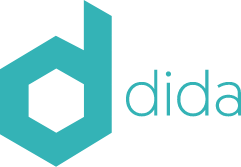

Mies krasser content am start hier.

In [1]:
DOWNLOAD_FILES = False
AUGMENT_FILES = False

In [2]:
import pytorch_lightning as pl
import requests
import Augmentor
import shutil
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from argparse import Namespace
from datetime import datetime


## Load the data from the dida Website
Leave out image 278 since the label data is corrupted 

In [3]:
if DOWNLOAD_FILES:
    import requests, zipfile, io
    r = requests.get('https://dida.do/assets/downloads/dida-test-task/dida_test_task.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./")

    !mkdir test_images train_images train_labels validation_images validation_labels augmented_labels augmented_validation_labels

    for test_image in ['images/535.png', 'images/537.png', 'images/539.png', 'images/551.png', 'images/553.png']:
        dest = test_image.split('/')[1]
        shutil.move(test_image, './test_images/' + dest)

    for train_image in ['images/121.png','images/241.png', 'images/270.png', 'images/272.png','images/274.png','images/284.png','images/287.png', 'images/300.png','images/301.png','images/303.png','images/308.png', 'images/314.png','images/315.png','images/317.png', 'images/320.png','images/324.png']:
        dest = train_image.split('/')[1]
        shutil.move(train_image, './train_images/' + dest)

    for train_label in ['labels/121.png','labels/241.png','labels/270.png','labels/272.png','labels/274.png','labels/284.png','labels/287.png','labels/300.png','labels/301.png','labels/303.png','labels/308.png','labels/314.png','labels/315.png','labels/317.png','labels/320.png','labels/324.png']:
        dest = train_label.split('/')[1]
        shutil.move(train_label, './train_labels/' + dest)

    for val_image in ['images/328.png', 'images/337.png', 'images/343.png', 'images/345.png', 'images/379.png', 'images/381.png', 'images/417.png', 'images/532.png']:
        dest = val_image.split('/')[1]
        shutil.move(val_image, './validation_images/' + dest)

    for val_label in ['labels/328.png', 'labels/337.png', 'labels/343.png', 'labels/345.png','labels/379.png', 'labels/381.png', 'labels/417.png', 'labels/532.png']:
        dest = val_label.split('/')[1]
        shutil.move(val_label, './validation_labels/' + dest)

## Use image augmentation on training data

In [4]:
if AUGMENT_FILES:
    ### AUGMENT THE TRAINING DATA
    p = Augmentor.Pipeline('train_images', output_directory='augmented_images')
    p.ground_truth('train_labels')

    p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.skew(probability=0.3)
    p.crop_random(0.5, percentage_area=0.7)
    p.resize(1, 256, 256)
    p.sample(1000)

    # move the files into the local directory
    shutil.move('./train_images/augmented_images', './augmented_images')

    # rename the files and split the generated labels and images into seperate folder 
    for file in os.listdir('augmented_images/'):
      new_name = file.split('_')[-1]
      if 'original' in file:
        shutil.move('augmented_images/' + file, 'augmented_images/' + new_name)
      if 'groundtruth' in file:
        shutil.move('augmented_images/' + file, 'augmented_labels/' + new_name)

## Apply the augmentation on the validation data

In [5]:
if AUGMENT_FILES:
    # same as above but with the validation data
    p = Augmentor.Pipeline('validation_images', output_directory='augmented_validation_images')
    p.ground_truth('validation_labels')

    p.random_distortion(probability=0.4, grid_width=4, grid_height=4, magnitude=4)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.skew(probability=0.3)
    p.crop_random(0.2, percentage_area=0.8)
    p.resize(1, 256, 256)
    p.sample(200)

    shutil.move('./validation_images/augmented_validation_images', './augmented_validation_images')

    for file in os.listdir('augmented_validation_images/'):
      new_name = file.split('_')[-1]
      if 'original' in file:
        shutil.move('augmented_validation_images/' + file, 'augmented_validation_images/' + new_name)
      if 'groundtruth' in file:
        shutil.move('augmented_validation_images/' + file, 'augmented_validation_labels/' + new_name)

## Build the dataset


In [6]:
class SegmentationDataset(Dataset):
  
    def __init__(self, img_path, segmentation_path, mean=0, std=1, preprocessor=None):
        self.X = []
        self.Y = []
        
        # load image paths
        for image_file in os.listdir(img_path):
            self.X.append(img_path + image_file)
            self.Y.append(segmentation_path + image_file)

        self.tr_y = transforms.ToTensor()
        self.tr_x = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)      
        ]) 
        self.preprocessor = preprocessor
    
    def get_raw(self, index):

        x = Image.open(self.X[index])
        x = self.tr_y(x)
        
        y = Image.open(self.Y[index])
        y = self.tr_y(y)
        
        return x, y
    
    def __getitem__(self, index):
        x = Image.open(self.X[index])
        x = self.tr_x(x)
        if self.preprocessor:
            x = self.preprocessor(x)
        
        y = Image.open(self.Y[index])
        y = self.tr_y(y)
        
        return x, y

    def __len__(self):
        return len(self.X) 

Calculate mean and std for the z normalization

In [7]:
# calcualte the mean and std of some representation image
print('Z nomarlization:')
tmp_data = SegmentationDataset('augmented_images/', 'augmented_labels/')
loader = DataLoader(tmp_data, batch_size=len(tmp_data))
mean, std = 0, 0
for x,y in loader:
    mean = x.mean()
    std = x.std()
print(f'Mean: {mean}, Std: {std}')

del tmp_data

Z nomarlization:
Mean: 0.44934770464897156, Std: 0.3490591049194336


## Create the data loader

In [9]:
train_data = SegmentationDataset('augmented_images/', 'augmented_labels/', mean=mean, std=std)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)

validation_data = SegmentationDataset('augmented_validation_images/', 'augmented_validation_labels/', mean=mean, std=std)
validation_loader = DataLoader(validation_data, batch_size=16, shuffle=False, num_workers=0)

## Show the data


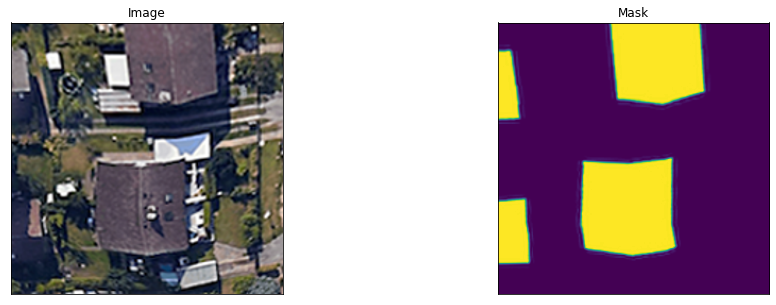

In [10]:
# helper function for data visualization
def visualize(safe=False, filename='out.png', **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        if type(image.size) == int:
          image = image.unsqueeze()
        
        if image.size()[0] == 4:
            image = image.permute(1,2,0)

        if image.size()[0] == 3:
            image = image.permute(1,2,0)
        elif image.size()[0] == 1:
            image = image.squeeze()

        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if safe:
        plt.savefig(filename)
    plt.show()

# exemplary use case  
image, mask = train_data.get_raw(0) 
visualize(
    image=image, 
    mask=mask.squeeze()
)

## Build the model


In [11]:

def UnionOverIntersection(prediction, label, final_sig=False):
    if final_sig:
        sig = nn.Sigmoid()
        inputs = sig(prediction)  
    prediction = prediction.view(-1)
    label = label.view(-1)

    union = torch.sum(label*prediction)
    intersection = torch.sum(label+prediction) - union

    return union/intersection


class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.sig = nn.Sigmoid()

    def forward(self, prediction, label, final_sig=False):
        #flatten label and prediction tensors
        if final_sig:
            prediction = self.sig(prediction)
        prediction = prediction.view(-1)
        label = label.view(-1)

        # calculate dice loss = (2*union)/(union + intersection) 
        # dice is the equivalent of the F1 score
        union = torch.sum(label*prediction)
        union_and_intersection = torch.sum(label+prediction)
        dice = 2*union/union_and_intersection
                       
        return 1 - dice

class SegmentationNetwork(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = hparams.batch_size
        self.lr = hparams.learning_rate
        args = {
            'encoder_name': hparams.backbone,  
            'encoder_weights': "imagenet", 
            'in_channels': 4,
            'classes': 1,
            'activation': 'sigmoid'
        }

        if hparams.architecture == 'unet':
            self.model = smp.Unet(**args)

        if hparams.architecture == 'unet++':
            self.model = smp.UnetPlusPlus(**args)

        if hparams.architecture == 'DeepLabV3':
            self.model = smp.DeepLabV3(**args)
            
        if hparams.freeze_encoder:
            pass

        self.best_validation_loss = 1
        self.loss = DiceLoss()

    def forward(self, x):    
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss(prediction, y)
        UoI = UnionOverIntersection(prediction, y)
        self.log('train/loss', float(loss))
        self.log('train/UnionOverIntersection', UoI, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, y = batch
            prediction = self(x)
            loss = self.loss(prediction, y)
            UoI = UnionOverIntersection(prediction, y)
            self.log('validation/loss', loss)
            self.log('validation/UnionOverIntersection', UoI, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        train_data = SegmentationDataset('augmented_images/', 'augmented_labels/', mean=mean, std=std)
        return DataLoader(train_data, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        validation_data = SegmentationDataset('augmented_validation_images/', 'augmented_validation_labels/', mean=mean, std=std)
        return DataLoader(validation_data, batch_size=self.batch_size, shuffle=False, num_workers=0)

def setup_experiment(hparams):
    experiment_folder = 'runs/'
    time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")



    model = SegmentationNetwork(hparams)

    logger = pl.loggers.TensorBoardLogger(experiment_folder, name='logs', version=f'{hparams.architecture}_{hparams.backbone}_{time}')

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='validation/loss',
        dirpath= experiment_folder + 'checkpoints',
        filename=f'{hparams.architecture}_{hparams.backbone}_{time}' + '_{epoch:02d}_{validation/loss:.2f}'
    )
    early_stopping = pl.callbacks.EarlyStopping(monitor='validation/loss',
                                                patience = 40)
    trainer = pl.Trainer(min_epochs=80,
                         max_epochs=150,
                         gpus=-1,
                         logger=logger,
                         callbacks=[checkpoint_callback, early_stopping])
#     trainer = pl.Trainer(min_epochs=150, 
#                          max_epochs=150,
#                          gpus=-1,
#                          logger=logger,
#                          callbacks=[checkpoint_callback])
    return trainer, model

Train the network!


In [17]:
# for architecture in ['unet']:
#     for backbone in ['efficientnet-b0']:
#         for lr in [0.0005]:
#             hparams = Namespace(**{
#                 'learning_rate': lr,
#                 'architecture': architecture,
#                 'backbone': backbone,
#                 'freeze_encoder': False,
#                 'batch_size': 4
#             })

#             trainer, model = setup_experiment(hparams)
#             torch.cuda.empty_cache()
#             trainer.fit(model)

Train the best configuration that we found!

In [18]:
architecture, backbone, lr = 'unet', 'efficientnet-b0', 0.0005
hparams = Namespace(**{
    'learning_rate': lr,
    'architecture': architecture,
    'backbone': backbone,
    'freeze_encoder': False,
    'batch_size': 4
})

trainer, model = setup_experiment(hparams)
torch.cuda.empty_cache()
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | Unet     | 6.3 M 
1 | loss  | DiceLoss | 0     
-----------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.007    Total estimated model params size (MB)


1

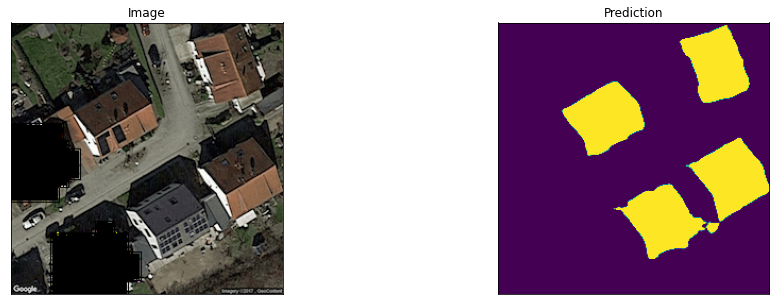

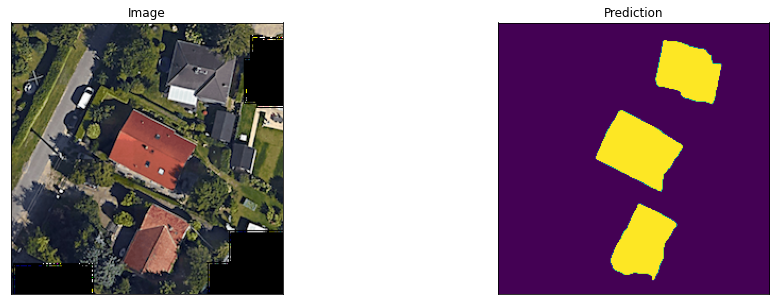

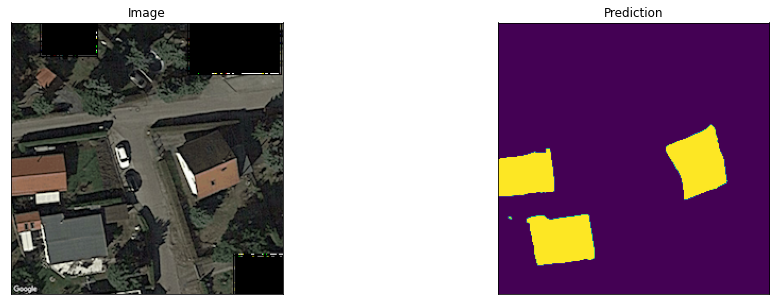

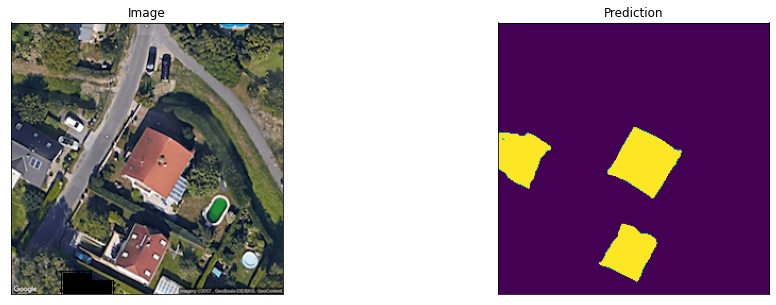

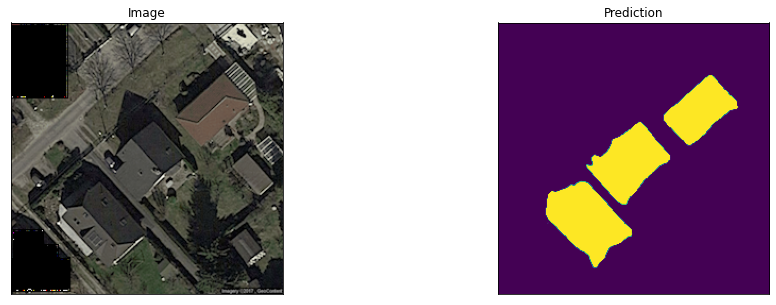

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tr = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std)      
]) 

img_tr = transforms.ToTensor()

images = [img_tr(Image.open('test_images/' + image_file).convert('RGB')) for image_file in os.listdir('test_images/')]
test = []

for image_file in os.listdir('test_images/'):
    img = tr(Image.open('test_images/' + image_file))
    test.append(img)

with torch.no_grad():
    test = torch.stack(test)
    prediction = model(test)
    test = test.to('cpu')
    prediction = prediction.to('cpu')
    for i in range(5):
        visualize(safe=True, filename=f'out_{i}.png', image=images[i], prediction=prediction[i])